In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customer_interactions = pd.read_csv('dataset/customer_interactions.csv')
purchase_history = pd.read_csv('dataset/purchase_history.csv')
product_details = pd.read_csv('dataset/product_details.csv')

# Data Cleansing

In [ ]:
print("customer interactions info: ")
customer_interactions.info()

In [ ]:
print("purchase history info:")
purchase_history.info()

In [ ]:
product_details.info()

In [3]:
# delimiters and drop empty columns from the purchase_history.csv
purchase_history = pd.read_csv('dataset/purchase_history.csv', delimiter=';')
drop_empty_ph = purchase_history.columns[3:]
purchase_history = purchase_history.drop(columns=drop_empty_ph)

In [4]:
# delimiters and drop empty columns from the product_details.csv
product_details = pd.read_csv('dataset/product_details.csv', delimiter=';')
drop_empty_pd = product_details.columns[4:]
product_details = product_details.drop(columns=drop_empty_pd)

In [5]:
merged_data = pd.merge(purchase_history, product_details, on="product_id")
merged_data = pd.merge(merged_data, customer_interactions, on='customer_id')

In [6]:
features = merged_data.groupby('customer_id').agg({
        'page_views': 'sum',
        'time_spent': 'sum',
        'price': 'mean',
        'ratings': 'mean',
    }).reset_index()

In [7]:
import random
from datetime import datetime, timedelta

In [8]:
additional_rows = 495
additional_data = []
for _ in range(additional_rows):
    category = random.choice(merged_data['category'])
    price_options = {
        'Electronics': [500, 800],
        'Clothing': [50],
        'Home & Kitchen': [200],
        'Beauty': [30]
    }[category]
    new_row = {
        "customer_id": random.choice(merged_data['customer_id']),
        "product_id": random.choice(merged_data['product_id']),
        "purchase_date": (datetime.strptime("2023-01-01", "%Y-%m-%d") + timedelta(days=random.randint(1, 365))).strftime("%Y-%m-%d"),
        "category": category,
        "price": random.choice(price_options),
        "ratings": round(random.uniform(1.0, 5.0)),
        "page_views": random.randint(10, 100),
        "time_spent": round(random.uniform(20, 150))
    }
    additional_data.append(new_row)
df = pd.concat([merged_data, pd.DataFrame(additional_data)], ignore_index=True)

### Feature Engineering

In [9]:
from sklearn.model_selection import train_test_split

X = merged_data[['page_views', 'time_spent', 'price', 'ratings']]
y = merged_data['product_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Visualization

### On Customer Interactions

In [10]:
plt.figure(figsize=(12, 6))

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Distribution of page views')

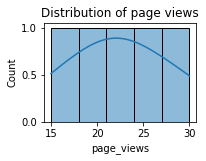

In [11]:
plt.subplot(2, 2, 1)
sns.histplot(customer_interactions['page_views'], bins=5, kde=True)
plt.title('Distribution of page views')

Text(0.5, 1.0, 'Distribution of Time Spent on website')

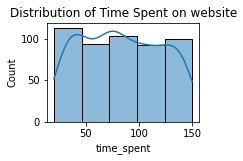

In [12]:
plt.subplot(2, 2, 2)
sns.histplot(df['time_spent'], bins=5, kde=True)
plt.title('Distribution of Time Spent on website')

Text(0.5, 1.0, 'Page Views vs Time Spent on Website')

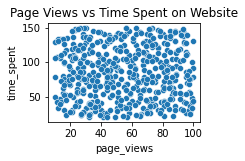

In [13]:
plt.subplot(2, 2, 3)
sns.scatterplot(x='page_views', y='time_spent', data=df)
plt.title('Page Views vs Time Spent on Website')

### on Purchase History

Text(0.5, 1.0, 'Monthly Purchase count')

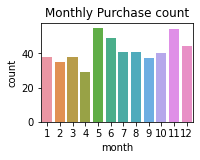

In [14]:
plt.subplot(2, 2, 1)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['month'] = df['purchase_date'].dt.month
sns.countplot(x='month', data=df)
plt.title('Monthly Purchase count')

Text(0.5, 1.0, 'Purchase Count by product')

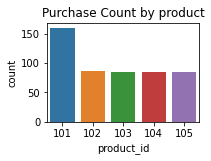

In [15]:
plt.subplot(2, 2, 2)
sns.countplot(x='product_id', data=df)
plt.title('Purchase Count by product')

Text(0.5, 1.0, 'Price Distribution by Category')

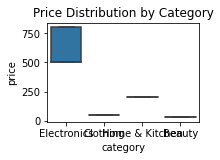

In [16]:
plt.subplot(2, 2, 1)
# sns.boxplot(x='category', y='price', data=pd.merge(purchase_history, product_details, on='product_id'))
sns.boxplot(x='category', y='price', data=df)
plt.title('Price Distribution by Category')

# Random Forest Classifier

### Training

In [17]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Build random forest classifier
model_RFC = RandomForestClassifier(n_estimators=100, random_state=42)
model_RFC.fit(X_train, y_train)

# save the model into .joblib file
joblib.dump(model_RFC, 'random_forest_model.joblib')

RandomForestClassifier(random_state=42)

### Evaluate

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import joblib

# load_model = joblib.load('random_forest_model.joblib')

In [22]:
y_pred_RFC = model_RFC.predict(X_test)

precision_RFC = precision_score(y_test, y_pred_RFC, average='weighted')
recall_RFC = recall_score(y_test, y_pred_RFC, average='weighted')
f1_RFC = f1_score(y_test, y_pred_RFC, average='weighted')
accuracy_RFC = accuracy_score(y_test, y_pred_RFC)

print("Precission: {:.2f}".format(precision_RFC))
print("Recall: {:.2f}".format(recall_RFC))
print("F1 Score: {:.2f}".format(f1_RFC))
print("Accuracy: {:.2f}".format(accuracy_RFC))

Precission: 0.25
Recall: 0.50
F1 Score: 0.33
Accuracy: 0.50


/home/legion/miniconda3/envs/mL/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Collaborative Filtering

In [23]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
import pickle
import joblib

In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(features[['customer_id', 'page_views', 'time_spent']], reader)

trainset = data.build_full_trainset()

sim_options = {
    'name': 'cosine',
    'user_based': False
}

In [30]:
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# joblib.dump(model, 'recommendation_model.joblib')

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [32]:
# evaluate the model
cross_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print(f"Mean RMSE: {cross_results['test_rmse'].mean()}")
print(f"Mean MAE: {cross_results['test_mae'].mean()}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    75.0000 145.0000235.000085.0000 105.0000129.000058.1722 
MAE (testset)     75.0000 145.0000235.000085.0000 105.0000129.000058.1722 
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Mean RMSE: 129.0
Mean MAE: 129.0


In [ ]:
user_id = 3
top_n = 10
user_neighbors = model.get_neighbors(user_id, k=top_n)

print(f"Top {top_n} Recommendations for User {user_id}")
for product_id in user_neighbors:
    print(f"Product ID: {product_id}")